In [1]:
import re
import nltk
from nltk.corpus import wordnet
from google.cloud import vision
import os

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = './hackrx-393212-93ebb5994abd.json'

In [2]:

def get_text_from_image(image_path):
    client = vision.ImageAnnotatorClient()

    with open(image_path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    all_text = ''

    for text in texts:
        all_text += text.description

    return all_text


In [3]:
def get_details(concat_output):
    match = re.findall(r'\d+[/.-]\d+[/.-]\d{4}', concat_output)

    bill_date = ""
    reciever = ""
    total_bill = 0

    bill_date = bill_date.join(match[0])

    sent_tokens = nltk.sent_tokenize(concat_output)
    reciever = sent_tokens[0].splitlines()[0]

    price = re.findall(r'[\$\$\£\€\₹](\d+(?:\.\d{1,2})?)', concat_output)
    if price:
        price = list(map(float, price))
        total_bill = max(price)

    return reciever, bill_date, total_bill

In [4]:
def process_text(concat_output):
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    new_words = tokenizer.tokenize(concat_output)

    nltk.download('stopwords')
    stop_words = set(nltk.corpus.stopwords.words('english'))

    filtered_list = [w.lower() for w in new_words if w not in stop_words]

    return filtered_list

In [5]:
def get_category(filtered_list):
    entertainment = []
    for syn in wordnet.synsets("entertainment"):
        for l in syn.lemmas():
            entertainment.append(l.name())

    l = ['happy', 'restaurant', 'food', 'kitchen', 'hotel',
         'room', 'park', 'movie', 'cinema', 'popcorn', 'combo', 'meal']
    entertainment = entertainment+l

    home_utility = []
    for syn in wordnet.synsets("home"):
        for l in syn.lemmas():
            home_utility.append(l.name())
    l2 = ['internet', 'rent', 'telephone', 'elecricity', 'meter', 'wifi', 'broadband',
          'consumer', 'reading', 'gas', 'water', 'postpaid', 'prepaid', 'airtel', 'jio']
    home_utility += l2

    grocery = []
    for syn in wordnet.synsets("grocery"):
        for l in syn.lemmas():
            grocery.append(l.name())
    l3 = ['bigbasket', 'milk', 'atta', 'sugar', 'suflower',
          'oil', 'bread', 'vegetabe', 'fruit', 'salt', 'paneer']
    grocery += l3

    investment = []
    for syn in wordnet.synsets("investment"):
        for l in syn.lemmas():
            investment.append(l.name())
    l1 = ['mutual', 'funds', 'endowment', 'grant', 'loan', 'applicant', 'income', 'expenditure', 'profit',
          'interest', 'expense', 'finance', 'property', 'money', 'fixed', 'deposit', 'kissan', 'vikas']
    investment = investment+l1

    transport = []
    for syn in wordnet.synsets("car"):
        for l in syn.lemmas():
            transport.append(l.name())
    l4 = ['cab', 'ola', 'uber', 'autorickshaw', 'railway', 'air',
          'emirates', 'aerofloat', 'taxi', 'booking', 'road', 'highway', 'petroleum', 'diesel', 'petrol', 'gas', 'fuel']
    transport += l4

    shopping = []
    for syn in wordnet.synsets("dress"):
        for l in syn.lemmas():
            shopping.append(l.name())
    l4 = ['amazon', 'myntra', 'flipkart', 'iphone', 'laptop', 'saree', 'max', 'pantaloons', 'westside', 'vedic', 'makeup',
          'lipstick', 'cosmetics', 'mac', 'facewash', 'heels', 'crocs', 'footwear', 'purse']
    shopping += l4

    bank_transfers = []
    for syn in wordnet.synsets("bank transfers"):
        for l in syn.lemmas():
            bank_transfers.append(l.name())

    l = ['icici', 'hdfc', 'yesbank', 'bajaj']
    bank_transfers = bank_transfers+l

    category = 'others'
    for word in filtered_list:
        if word in entertainment:
            category = 'entertainment'
            break
        elif word in investment:
            category = 'investment'
            break
        elif word in grocery:
            category = 'grocery'
            break
        elif word in shopping:
            category = 'shopping'
            break
        elif word in transport:
            category = 'transport'
            break
        elif word in home_utility:
            category = 'home_utility'
            break

    return category

In [6]:
def get_bill_details(image_path):
    text = get_text_from_image(image_path)
    reciever, bill_date, total_bill = get_details(text)
    filtered_list = process_text(text)
    category = get_category(filtered_list)

    return reciever, bill_date, total_bill, category

In [7]:
def get_gov_doc(image_path):
    text = get_text_from_image(image_path)
    match = re.findall(r'\d+[/.-]\d+[/.-]\d{4}', text)

    dob = ""
    number = ""

    dob = dob.join(match)

    sent_tokens = nltk.sent_tokenize(text)
    number = sent_tokens[0].splitlines()[5]

    return dob, number


In [8]:
reciever, bill_date, total_bill, category = get_bill_details('test.png')
dob, number = get_gov_doc('doc.jpg')
print(reciever, bill_date, total_bill, category)
print(dob, number)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Ying Thai Kitchen 7/4/2013 12.59 entertainment
01/01/197801/01/1978 গগন প্রমানিক


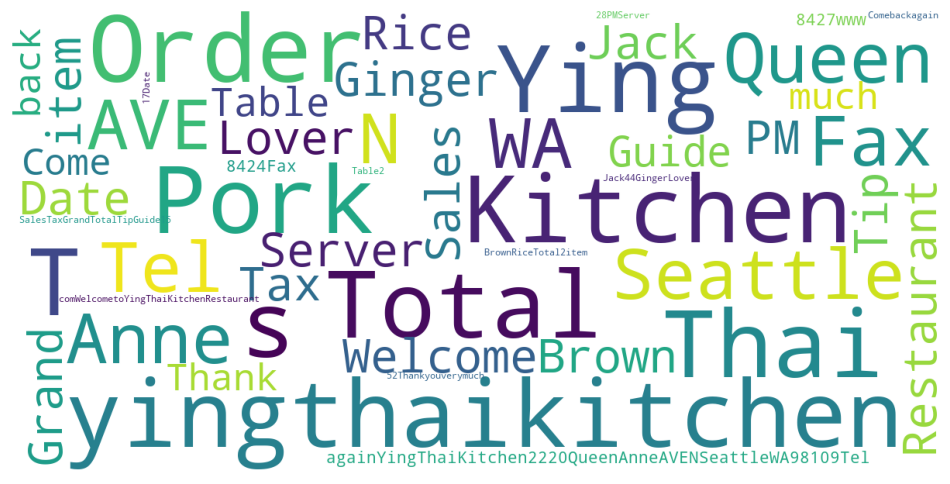

In [9]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

text = get_text_from_image('./test.png')
show_wordcloud(text)